# Smoke Detector Classification
## source: https://www.kaggle.com/datasets/deepcontractor/smoke-detection-dataset
### Import packages

In [72]:

#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from plotly.subplots import  make_subplots
import matplotlib.pyplot as plt

import plotly.express as px
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier


from sklearn.metrics import accuracy_score
import time

import warnings
warnings.filterwarnings('ignore')



## Data Exploration
### Feature Description:
1. UTC - Time of the experiment
2. Temperature - The aie temperature, in celsius
3. Humidity - air humidity, in percents
4. TVOC - Total Volatile Organic Compounds, in parts per billion
5. Co2e - CO2 equivalent concentration, in parts per million
6. Raw H2 - Raw hydrogen levels, in parts per million
7. Raw Ethanol - raw ethanol gas amounts
8. Pressure - air pressure, in hectopascal
9. PM1.0 - Paticulate matter of diameter less than 1.0 micrometer
10. PM2.5 - Paticulate matter of diameter less than 2.5 micrometer
11. NC0.5 - Concentration of particulate matter of diameter less than micrometers.
12. NC1.0 - Concentration of particulate matter of diameter less than 1.0 micrometers.
13. NC2.5 - Concentration of particulate matter of diameter less than 2.5 micrometers.
14. CNT - Simple Count.
15. Fire Alarm - (Reality) If fire was present then value is 1 else it is 0.

In [73]:
## Load Data
data = pd.read_csv('smoke_detection_iot.csv', index_col=False)
data.head

<bound method NDFrame.head of        Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  \
0               0  1654733331          20.000        57.36          0   
1               1  1654733332          20.015        56.67          0   
2               2  1654733333          20.029        55.96          0   
3               3  1654733334          20.044        55.28          0   
4               4  1654733335          20.059        54.69          0   
...           ...         ...             ...          ...        ...   
62625       62625  1655130047          18.438        15.79        625   
62626       62626  1655130048          18.653        15.87        612   
62627       62627  1655130049          18.867        15.84        627   
62628       62628  1655130050          19.083        16.04        638   
62629       62629  1655130051          19.299        16.52        643   

       eCO2[ppm]  Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  \
0            400

In [74]:
data.shape

(62630, 16)

In [75]:
data.describe().T.sort_values(ascending=0, by = "mean").style.background_gradient(cmap = "BuGn")\
.bar(subset = ["std"], color = "red").bar(subset = ["mean"], color = "blue")


,count,mean,std,min,25%,50%,75%,max
UTC,62630.000000,1654792066.184273,110002.488078,1654712187.000000,1654743244.250000,1654761919.500000,1654777576.750000,1655130051.000000
Unnamed: 0,62630.000000,31314.500000,18079.868017,0.000000,15657.250000,31314.500000,46971.750000,62629.000000
Raw Ethanol,62630.000000,19754.257912,609.513156,15317.000000,19435.000000,19501.000000,20078.000000,21410.000000
Raw H2,62630.000000,12942.453936,272.464305,10668.000000,12830.000000,12924.000000,13109.000000,13803.000000
CNT,62630.000000,10511.386157,7597.870997,0.000000,3625.250000,9336.000000,17164.750000,24993.000000
TVOC[ppb],62630.000000,1942.057528,7811.589055,0.000000,130.000000,981.000000,1189.000000,60000.000000
Pressure[hPa],62630.000000,938.627649,1.331344,930.852000,938.700000,938.816000,939.418000,939.861000
eCO2[ppm],62630.000000,670.021044,1905.885439,400.000000,400.000000,400.000000,438.000000,60000.000000
NC0.5,62630.000000,491.463608,4265.661251,0.000000,8.820000,12.450000,14.420000,61482.030000
NC1.0,62630.000000,203.586487,2214.738556,0.000000,1.384000,1.943000,2.249000,51914.680000


In [76]:
## Get unique values
features = data.columns
for feature in features:
    print(f"{feature} ---> {data[feature].nunique()}")

Unnamed: 0 ---> 62630
UTC ---> 62630
Temperature[C] ---> 21672
Humidity[%] ---> 3890
TVOC[ppb] ---> 1966
eCO2[ppm] ---> 1713
Raw H2 ---> 1830
Raw Ethanol ---> 2659
Pressure[hPa] ---> 2213
PM1.0 ---> 1337
PM2.5 ---> 1351
NC0.5 ---> 3093
NC1.0 ---> 4113
NC2.5 ---> 1161
CNT ---> 24994
Fire Alarm ---> 2


In [77]:
## null values
data.isna().sum()

Unnamed: 0        0
UTC               0
Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
Fire Alarm        0
dtype: int64

<AxesSubplot:>

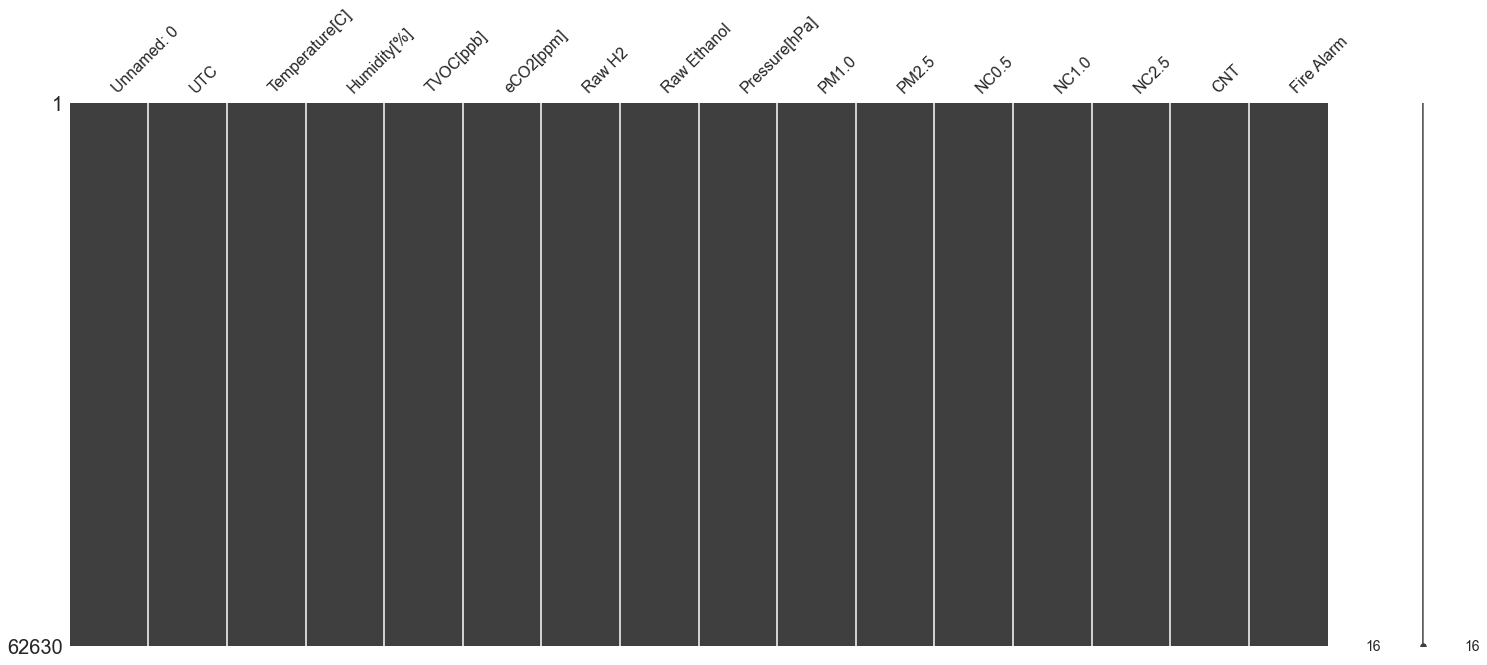

In [78]:
## visualize missing data
msno.matrix(data)

## Data Cleaning
Since there are no missing values, we need to do nothing.
Some values are useless: UTC, Unamed: 0 and CNT


In [79]:
## drop useless columns
data = data.drop(['UTC','Unnamed: 0', 'CNT'], axis = 1)
data.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0


In [80]:
data.shape

(62630, 13)

In [81]:
data.describe().T.sort_values(ascending = 0,by = "mean").style.background_gradient(cmap = "BuGn")\
.bar(subset = ["std"], color ="red").bar(subset = ["mean"], color ="blue")

,count,mean,std,min,25%,50%,75%,max
Raw Ethanol,62630.000000,19754.257912,609.513156,15317.000000,19435.000000,19501.000000,20078.000000,21410.000000
Raw H2,62630.000000,12942.453936,272.464305,10668.000000,12830.000000,12924.000000,13109.000000,13803.000000
TVOC[ppb],62630.000000,1942.057528,7811.589055,0.000000,130.000000,981.000000,1189.000000,60000.000000
Pressure[hPa],62630.000000,938.627649,1.331344,930.852000,938.700000,938.816000,939.418000,939.861000
eCO2[ppm],62630.000000,670.021044,1905.885439,400.000000,400.000000,400.000000,438.000000,60000.000000
NC0.5,62630.000000,491.463608,4265.661251,0.000000,8.820000,12.450000,14.420000,61482.030000
NC1.0,62630.000000,203.586487,2214.738556,0.000000,1.384000,1.943000,2.249000,51914.680000
PM2.5,62630.000000,184.467770,1976.305615,0.000000,1.340000,1.880000,2.180000,45432.260000
PM1.0,62630.000000,100.594309,922.524245,0.000000,1.280000,1.810000,2.090000,14333.690000
NC2.5,62630.000000,80.049042,1083.383189,0.000000,0.033000,0.044000,0.051000,30026.438000


## Exploratory Data Analysis
### Feature analysis using target value

<AxesSubplot:xlabel='Fire Alarm', ylabel='Count'>

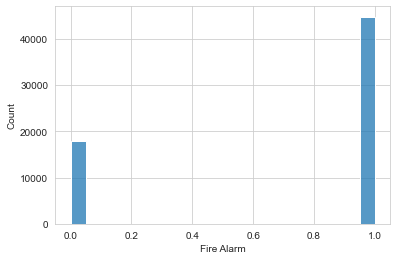

In [82]:
sns.set_style("whitegrid")
sns.histplot(data['Fire Alarm'])

In [83]:
zeros = 100*sum(data['Fire Alarm'] == 0)/data.shape[0]
ones = 100*sum(data['Fire Alarm'] == 1)/data.shape[0]
print(f" one: {round(ones,2)}% , zero: {round(zeros,2)}%")

 one: 71.46% , zero: 28.54%


<AxesSubplot:xlabel='eCO2[ppm]', ylabel='Density'>

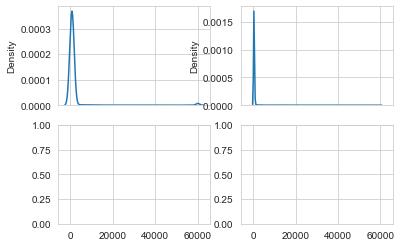

In [84]:
fig, axes = plt.subplots(2,2, sharex=True)
sns.kdeplot(ax = axes[0, 0], data = data,x = 'TVOC[ppb]')
sns.kdeplot(ax = axes[0, 1] ,data = data,x = 'eCO2[ppm]')

In [85]:
features = data.keys()
features = features.drop('Fire Alarm')
subsets = ['TVOC[ppb]','PM1.0','PM2.5','NC0.5','NC1.0','NC2.5']
data.groupby('Fire Alarm')[features].mean().style\
    .bar(subset = subsets, color = "red")

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
Fire Alarm,,,,,,,,,,,,
0,19.694803,42.930077,4596.587255,962.587255,12896.316847,20082.823533,938.101383,261.982706,450.034639,1356.283816,493.872027,178.982259
1,14.483152,50.779534,882.013071,553.189356,12960.878053,19623.050428,938.837806,36.146406,78.417842,146.111337,87.665549,40.541627


In [86]:
data.groupby('Fire Alarm')[features].median().style\
    .bar(subset = subsets, color = "red")

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5
Fire Alarm,,,,,,,,,,,,
0,20.540000,46.140000,86.000000,400.000000,12837.000000,20158.000000,937.478000,1.450000,1.520000,9.970000,1.578000,0.039000
1,20.020000,51.400000,1103.000000,404.000000,12933.000000,19454.000000,938.878000,1.870000,1.940000,12.860000,2.005000,0.045000


<AxesSubplot:>

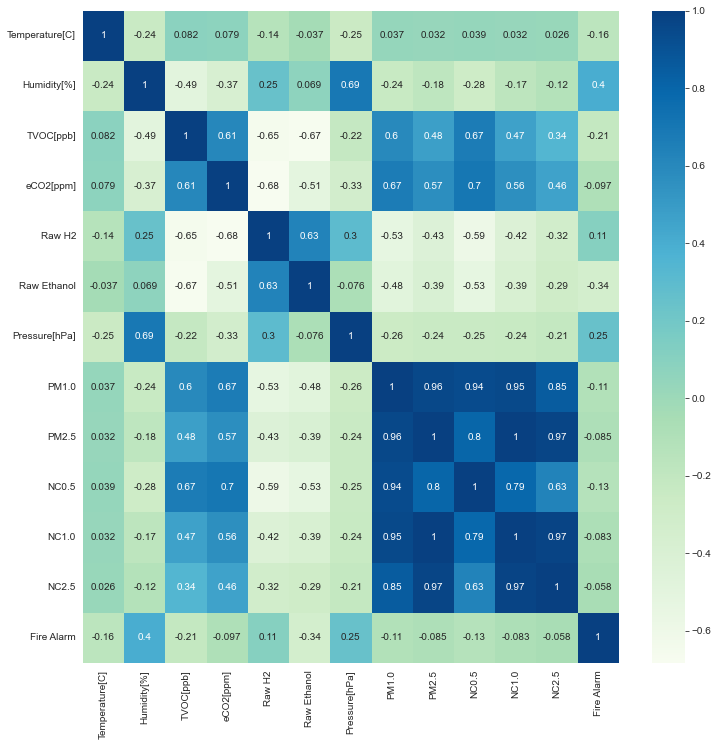

In [87]:
plt.figure(figsize = (12,12))
sns.heatmap(data.corr(),annot = True,cmap = 'GnBu')

Let's define high correlation >= 0.65
We can see that PM's and NC's are highly correlated

## Modelling

In [88]:
X = data.copy();
X = X.drop('Fire Alarm', axis = 1)
y = data['Fire Alarm']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2)
X_train.head
X_test.head

<bound method NDFrame.head of        Temperature[C]  Humidity[%]  TVOC[ppb]  eCO2[ppm]  Raw H2  Raw Ethanol  \
40143          27.140        47.02       1061        427   12876        19460   
39764          26.720        48.53       1145        454   12870        19452   
10007          -2.851        50.81        845        725   12770        19523   
29934          22.280        48.84         29        400   13255        20193   
40521          24.650        52.87       1138        427   12871        19439   
...               ...          ...        ...        ...     ...          ...   
4440           -4.750        54.22         94        400   13237        20118   
26683          16.280        53.66          8        400   13142        20035   
15290          12.453        53.06       1143        445   12868        19444   
27306          19.930        48.60         16        400   13211        20141   
27523          17.830        53.41         58        400   13193        20107  

In [89]:

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Implement Model

In [90]:
models = [KNeighborsClassifier(), SGDClassifier(), LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), BaggingClassifier(), SVC(), GaussianNB(), DummyClassifier(), ExtraTreeClassifier()]

In [91]:
Name = []
Accuracy = []
Time_Taken = []
for model in models:
    Name.append(type(model).__name__)
    begin = time.time()
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    end = time.time()
    accScore = accuracy_score(prediction,y_test)
    Accuracy.append(accScore)
    Time_Taken.append(end-begin)

In [92]:
Dict = {'Name':Name,'Accuracy':Accuracy,'Time Taken':Time_Taken}
model_df = pd.DataFrame(Dict)
model_df

,Name,Accuracy,Time Taken
0,KNeighborsClassifier,0.998483,1.441042
1,SGDClassifier,0.910666,0.046900
2,LogisticRegression,0.898930,0.133698
3,RandomForestClassifier,1.000000,2.975077
4,GradientBoostingClassifier,0.999681,7.645566
5,AdaBoostClassifier,0.999361,1.808055
6,BaggingClassifier,1.000000,0.820808
7,SVC,0.966709,18.877546
8,GaussianNB,0.767524,0.013962
9,DummyClassifier,0.716989,0.000997


In [94]:
model_df.sort_values(by = 'Accuracy',ascending = False,inplace = True)
fig = px.bar(model_df, x="Name", y="Accuracy", title='Accuracy VS Model')
fig.show()

In [95]:
model_df.sort_values(by = 'Time Taken',ascending = False,inplace = True)
fig = px.bar(model_df, x="Name", y="Time Taken", title='Time Taken VS Model')
fig.show()